# Проект по построению модели определения стоимости автомобилей

## Введение 

**Вводные данные проекта:**

**Заказчик:** сервис по продаже автомобилей с пробегом «Не бит, не крашен».

**Цель проекта:** построить модель определения стоимости автомобилей для клиентского сервиса по быстрой оценке рыночной стоимости автомобиля в приложении заказчика.

**Дополнительные условия заказчика:**
- высокое качество предсказания;
- высокая скорость предсказания;
- минимальное время обучения модели.

**Данные для анализа и построения модели:** технические характеристики, комплектации и цены автомобилей (исторические данные).


**Описание данных:**

Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:
- Price — цена (евро)

## Подготовка данных

### Загрузка данных

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-learn==1.1.3

Note: you may need to restart the kernel to use updated packages.


In [3]:
# необходимые библиотеки
# для работы с данными (предобработка, исследовательский анализ)
import pandas as pd
import numpy as np
import time

# для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# для машинного обучения
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
import lightgbm as ltb

In [4]:
# константа
SEED = 12345

In [5]:
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Функции для оптимизации работы с подготовкой данных

In [6]:
def info_all(data):
    '''функция оценивает общую информацию о данных'''
    print('-'*50)
    print('Общая информация о данных')
    temp = data.copy() 
    list_c = data.columns
    print(temp.info())
    for col_l in list_c:
        print('-'* 25)
        print(col_l, temp[col_l].sort_values().unique())
        print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')
    print('-'*50)    
    display(data.describe()) 
    print('-'*50) 
    print('Поиск дубликатов')
    if data.duplicated().sum() == 0:
        print('Дубликаты по строкам отсутствуют')
    else:
        print('Количество дублирующихся строк:', data.duplicated().sum())
        display(data.loc[data.duplicated() == True])

In [7]:
def graph_kat(data, data_label1, data_label2=''):
    '''строит диаграммы по количеству объектов в категориальных признаках'''
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(data_label1 + ". Количество по категориям", fontsize=18)
    g = sns.countplot(data=data, x=data_label1, ax=axes[0], palette='pastel')
    g.set_xticklabels(g.get_xticklabels(), rotation=90)
    if data_label2 != '':
        axes[1].set_title(data_label2 + ". Количество по категориям", fontsize=18)
        g = sns.countplot(data=data, x=data_label2, ax=axes[1], palette='pastel')
        g.set_xticklabels(g.get_xticklabels(), rotation=90)
    plt.show()

In [8]:
def graph(data, data_label, num_bins, log_scale=False):
    '''строит гистограммы histplot и boxplot для оценки распределения количественных признаков'''
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(data_label + ". Плотность распределения", fontsize=18)
    axes[0].set_ylabel('плотность', fontsize=15)
    sns.histplot(data, bins=num_bins, ax=axes[0], color='seagreen', kde=True)
    axes[1].set_title(data_label + ". Boxplot", fontsize=18)
    sns.boxplot(data=data, x=data.index, ax=axes[1], color='mediumspringgreen')
    plt.show()

### Общая информация о данных

In [9]:
# посмотрим общую информацию о данных
info_all(data)

--------------------------------------------------
Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


--------------------------------------------------
Поиск дубликатов
Количество дублирующихся строк: 4


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


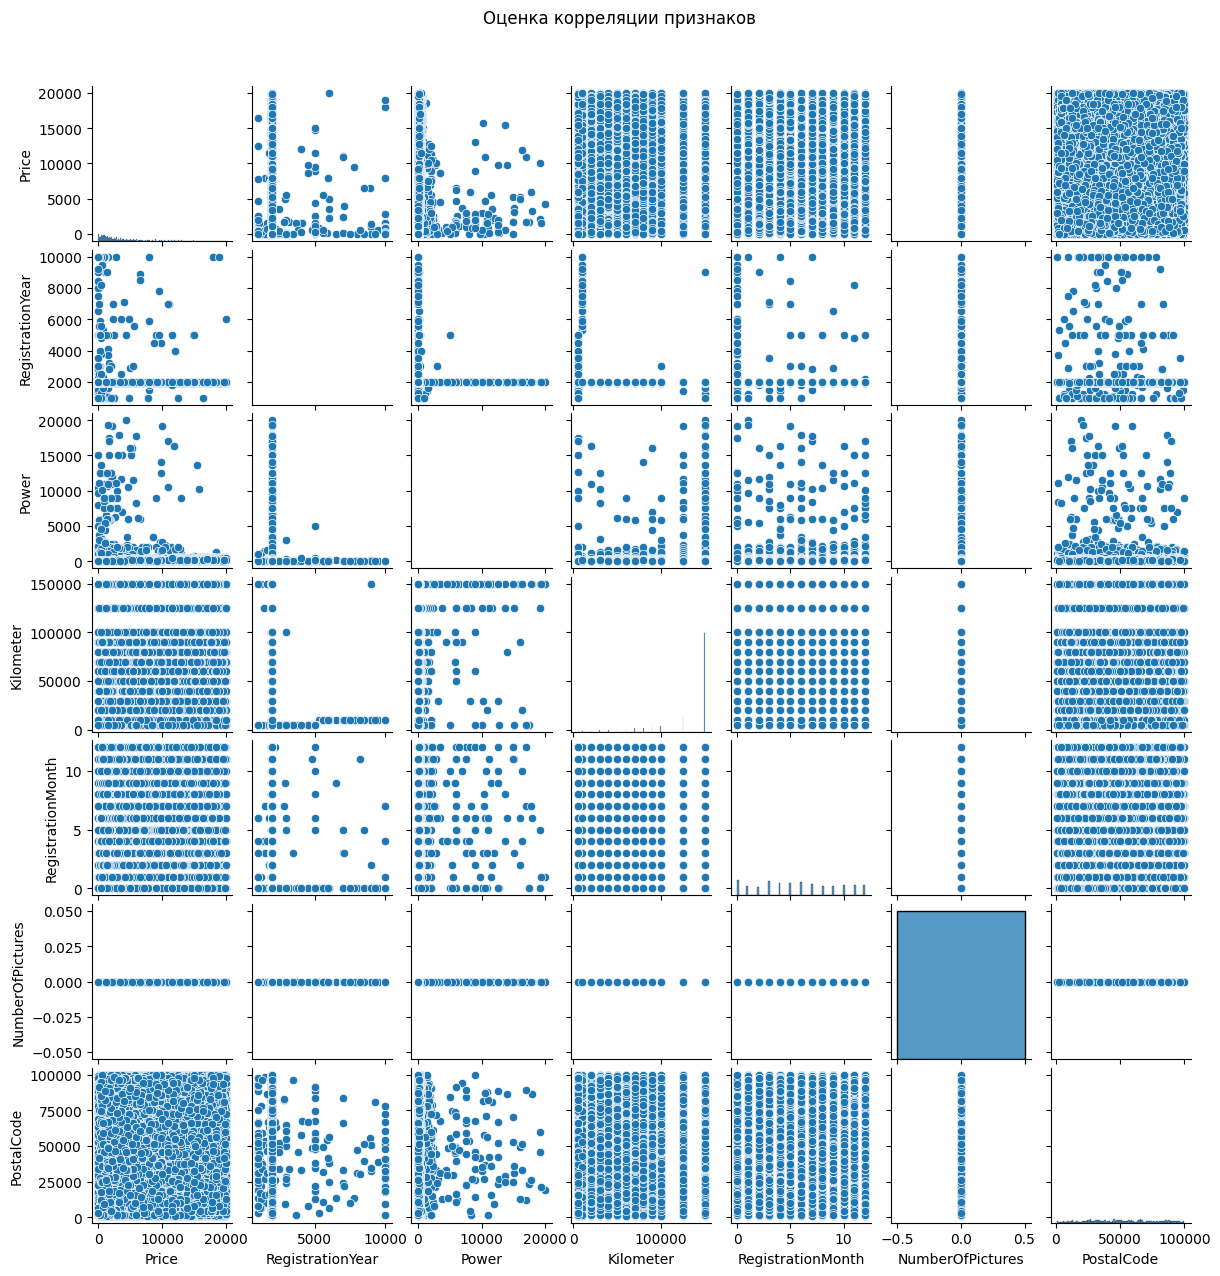

In [10]:
sns.pairplot(data)
plt.suptitle("Оценка корреляции признаков", y=1.05)
plt.gcf().set_size_inches(12,12)
plt.show()

**Выводы по оценке общей информации о данных:**
- нужно привести название признаков в удобный для обработки формат (нижний регистр).
- типы данных определены верно.
- имеются дубликаты (4 объекта).
- в датафрейме имеются признаки (столбцы), которые не принесут пользы при обучении модели (неинформативны):
    - DateCrawled — дата скачивания анкеты из базы;
    - NumberOfPictures — количество фотографий автомобиля;
    - DateCreated — дата создания анкеты;
    - PostalCode — почтовый индекс владельца анкеты (пользователя);
    - LastSeen — дата последней активности пользователя. 
- в признаке RegistrationYear (год регистрации) имеются нетипичные значения (менее 1886 (год изобретения автомобиля) и более 2016). Необходимо посмотреть сколько таких значений, если их не много, то лучше их удалить, так как год регистрации врятли удастся восстановить (скорее всего, это опечатки).
- в целевом признаке Price (цена) имеются нетипичные значения, например, 0 и 1 евро.
- в признаке Power (мощность, л.с.) имеются нетипичные значения - менее 10 лошадиных сил и 0. 
- имеются пропуски в следующих признаках:
    - VehicleType (тип кузова) (10.58%)
    - Gearbox (тип коробки передач) (5.6%)
    - Model (модель авто) (5.56%)
    - FuelType (тип топлива) (9.28%)
    - Repaired (был ли ремонт авто) (20.08%)
- явных взаимосвязей в данных не выявлено (оценка корреляции).    

### Предобработка данных

В рамках предобработки данных выполним следующие действия:
1. Удалим дубликаты и неинформативные признаки.
2. Для пропусков проведем детальный анализ:
    - выявим предположительную причину появления этих пропусков, построим тепловую карту пропущенных значений (для оценки пересечений);
    - оценим возможность их заполнения и подберем способ заполнения (при необходимости);
    - примем решение об удалении объектов, где нет возможности заполнения пропусков.
3. Для аномальных (нетипичных) значений построим диаграмму плотности и боксплоты. Оценим результаты и возможность удаления.

#### Удаление дубликатов, лишних данных и преобразование названий признаков

In [11]:
# удаляем дубликаты
data = data.drop_duplicates()
data.duplicated().sum()

0

In [12]:
# удаляем неинформативные признаки
data = data.drop(['DateCrawled', 'NumberOfPictures', 'DateCreated', 'PostalCode', 'LastSeen', 'RegistrationMonth'], axis=1)

In [13]:
# преобразуем название признаков в нижний змеиный регистр
data = data.rename(columns={"VehicleType": "Vehicle_Type", "RegistrationYear": "Registration_Year", "FuelType": "Fuel_Type"})
data.columns = data.columns.str.lower()
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


#### Обработка пропущенных значений

В признаке тип модели автомобиля имеются пропуски (5.6%), без этой информации определить стоимость авто будет затруднительно, поэтому удалим эти объекты из датафрейма.

Кроме того, в приложении заказчика поле модель должно быть обязательным, пропишем это в рекомендациях в выводах проекта.

In [14]:
# создаем копию, чтобы в конце посчитать процент удаленных значений
data_all = data

In [15]:
data = data.loc[data['model'].isna() == False]

In [16]:
# посмотрим сколько пропуском осталось
data.isna().sum().sort_values(ascending=False)

repaired             62100
vehicle_type         30662
fuel_type            25732
gearbox              15702
price                    0
registration_year        0
power                    0
model                    0
kilometer                0
brand                    0
dtype: int64

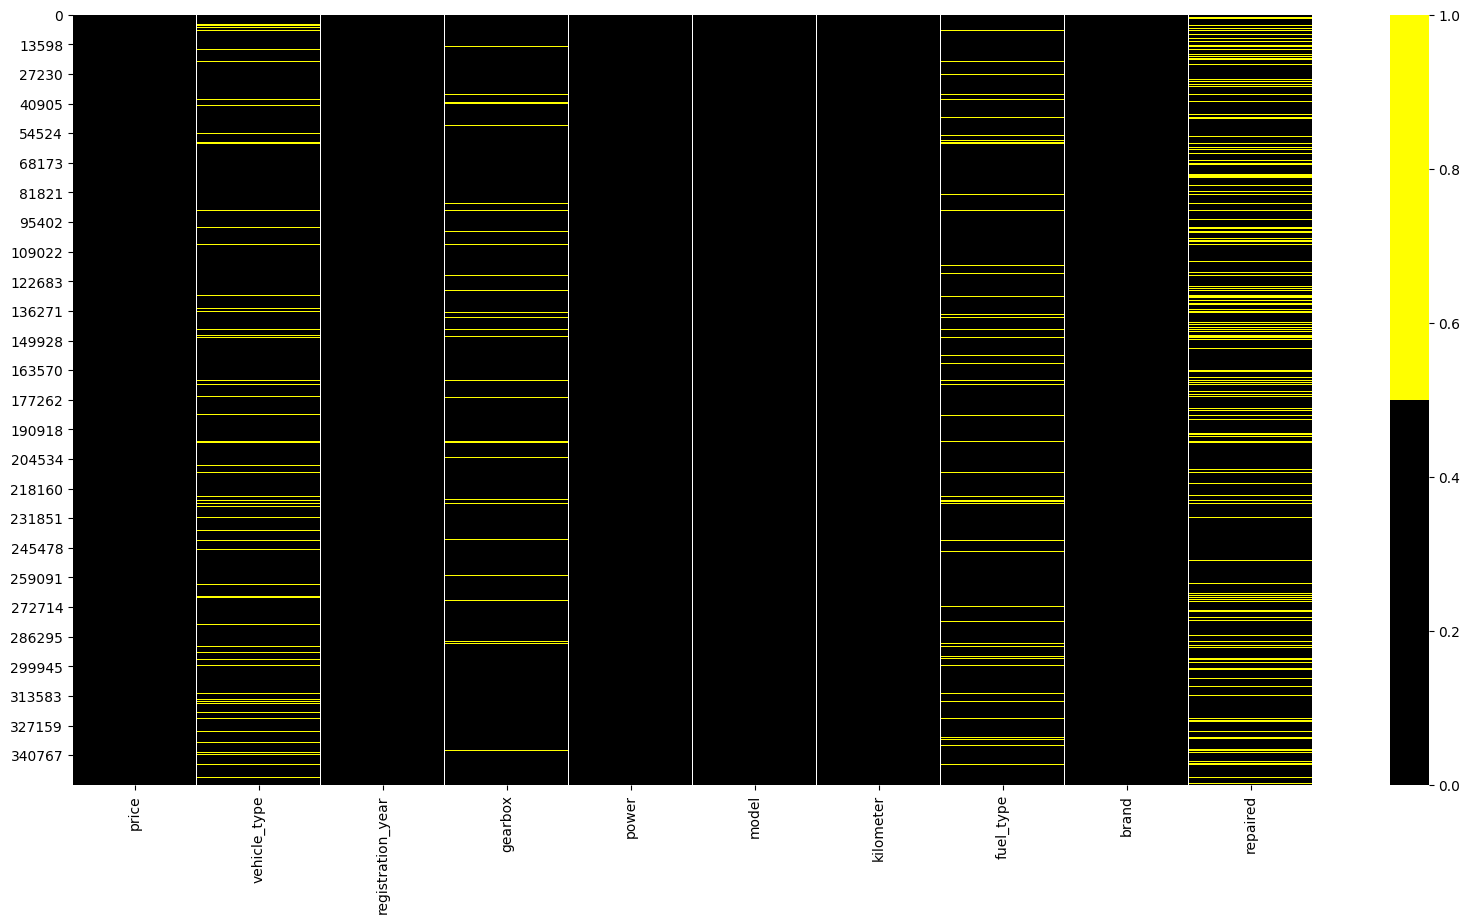

In [17]:
# построим тепловую карту по пропущенным значениям
cols = data.columns
# желтый - пропущенные данные, черный - не пропущенные
colours = ['black', 'yellow'] 
sns.heatmap(data[cols].isnull(), cmap=sns.color_palette(colours))
plt.gcf().set_size_inches(20,10)
plt.show()

Наибольшее количество пропущенных значений в признаке о наличии либо отсутствии ремонта авто. Предположительно пропуски могли появится в следующих случаях:
- ремонт машины не производился (ремонта не было и поле просто не заполнили);
- владелец заведомо не указывает данные о том, что ремонт проводился.

Удалить эти данные мы не можем, так как потеряем значительный процент информации по другим параметрам авто, поэтому заполним пропуски 'unknown' (неизвестно). Это позволит обучить модели, где пропуски не допустимы, а также не повлияет на результат модели, где пропуски допустимы и выносятся в отдельную категорию (catboost).

Заполним пропуски после рассмотрения остальных признаков.

Теперь поработаем с пропусками в параметрах автомобилей.

Сначала рассмотрим пропуски в типах кузова:

In [18]:
data.query('vehicle_type.isna() == True').pivot_table(index=['brand', 'model', 'gearbox', 'fuel_type'], 
                                                      aggfunc='count')['price'].sort_values(ascending=False)

brand          model     gearbox  fuel_type
volkswagen     golf      manual   petrol       1688
opel           corsa     manual   petrol        678
volkswagen     polo      manual   petrol        660
opel           astra     manual   petrol        477
bmw            3er       manual   petrol        457
                                               ... 
skoda          other     manual   lpg             1
citroen        berlingo  auto     petrol          1
chrysler       voyager   manual   petrol          1
mercedes_benz  v_klasse  manual   gasoline        1
suzuki         swift     auto     lpg             1
Name: price, Length: 800, dtype: int64

Отсутствующие значения имеются по многим маркам и моделям авто. Восстановить их по одинаковой модели и марке не выйдет, так как возможны вариации кузова. Тоже самое можно отметить и про тип коробки передач, и про тип топлива. Поэтому заменим пропуски 'unknown', чтобы не потерять прочие параметры при удалении пропущенных значений.

In [19]:
# заменяем оставшиеся пропуски в данных
data = data.fillna('unknown')
data.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

Пропуски в данных отсутствуют.

Далее оценим распределение признаков и аномалии в данных.

#### Оценка категориальных признаков

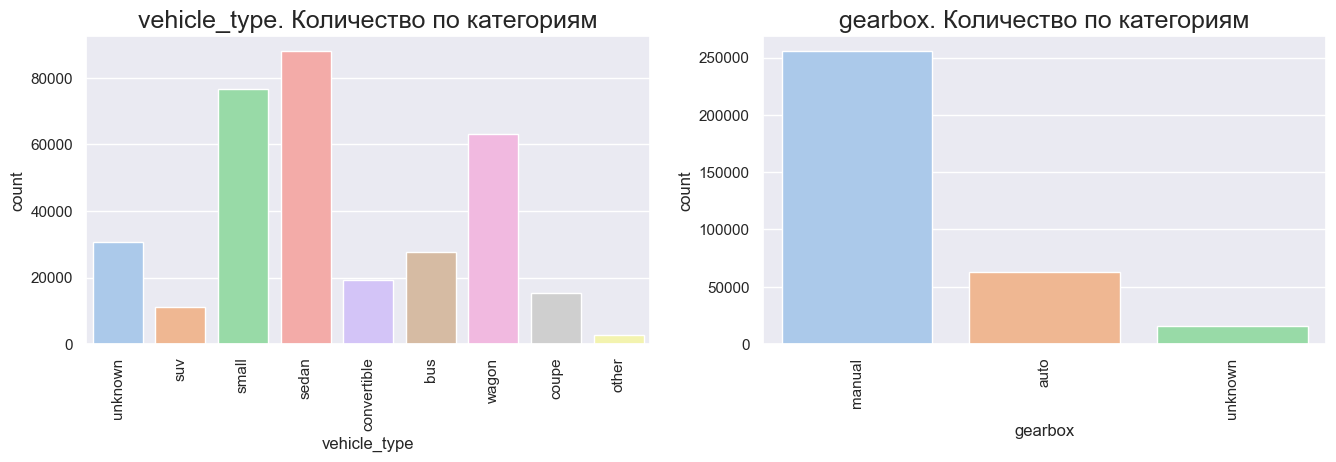

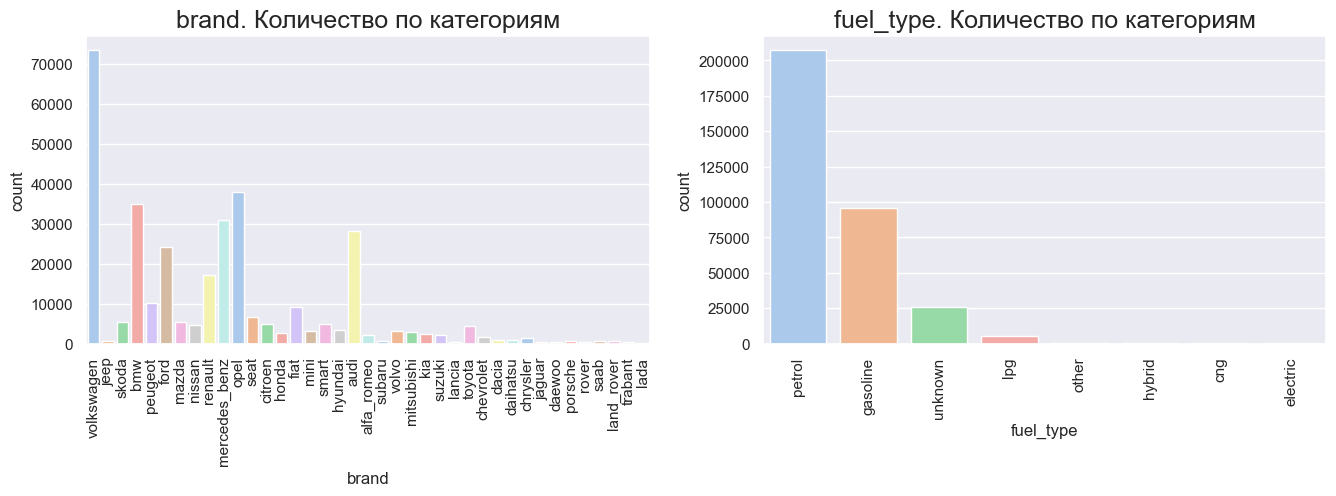

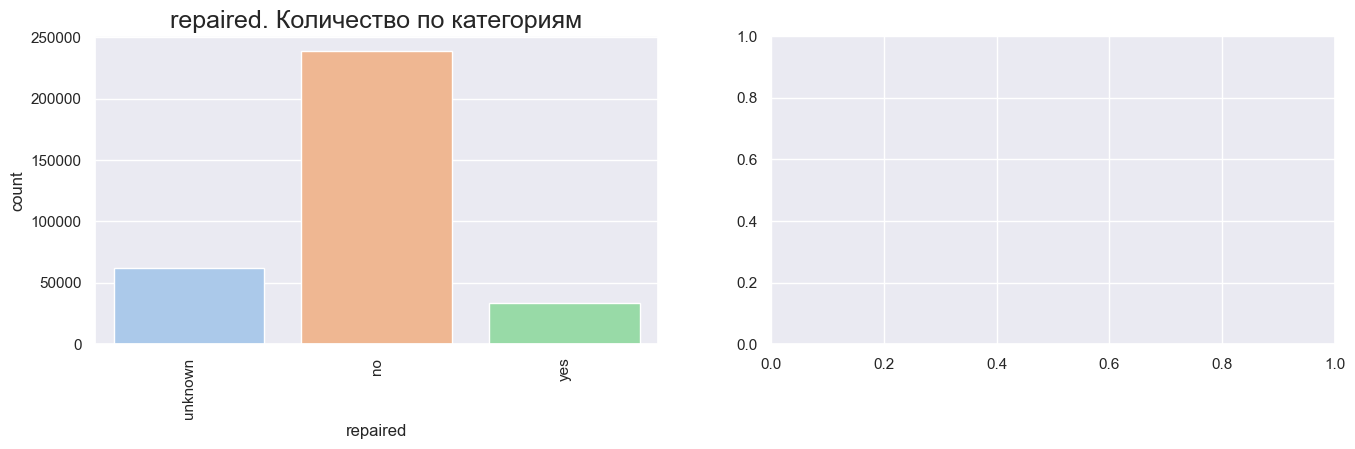

In [20]:
# построим диаграммы по количеству объектов в категориальных признаках
categories = ['vehicle_type', 'gearbox', 'brand', 'fuel_type', 'repaired', '']
for i in range(len(categories)//2):
    graph_kat(data, categories[2*i], categories[2*i+1])

Распределение всех моделей авто не информативно на графике, поэтому посмотрим самые популярные модели с указанием брендов в табличной форме:

In [21]:
data_brand = data.pivot_table(index=['brand', 'model'], values='price', 
                                    aggfunc='count')['price'].sort_values( ascending=False)
top_model = data_brand.head(15)
print('ТОП-15 моделей (с указанием бренда) в датафрейме')
display(top_model)

ТОП-15 моделей (с указанием бренда) в датафрейме


brand          model   
volkswagen     golf        29232
bmw            3er         19761
volkswagen     polo        13066
opel           corsa       12570
               astra       10809
volkswagen     passat      10145
audi           a4           9900
mercedes_benz  c_klasse     8312
bmw            5er          7868
mercedes_benz  e_klasse     6785
audi           a3           6122
ford           focus        5874
               fiesta       5774
audi           a6           5541
renault        twingo       4953
Name: price, dtype: int64

Из проведенной оценки распределения категориальных признаков можно дать обобщенный портрет чаще всего продаваемых авто:
   - брэнд: volkswagen;
   - модели: volkswagen golf, bmw 3er, volkswagen polo; 
   - тип кузова: sedan, small и wagon;
   - коробка передач: ручная (manual);
   - тип топлива: бензин (petrol);
   - ремонт авто отсутствует. 

####  Оценка распределения количественных признаков

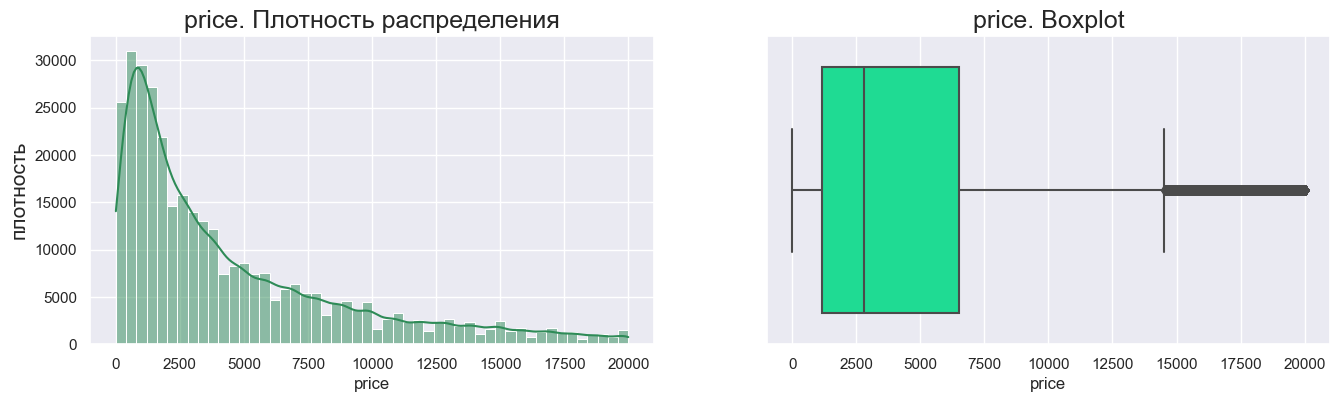

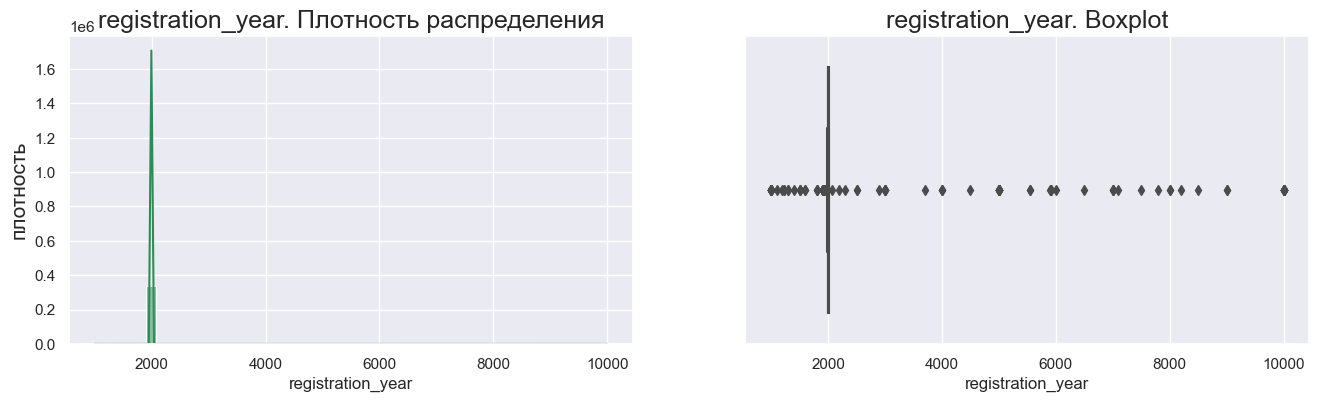

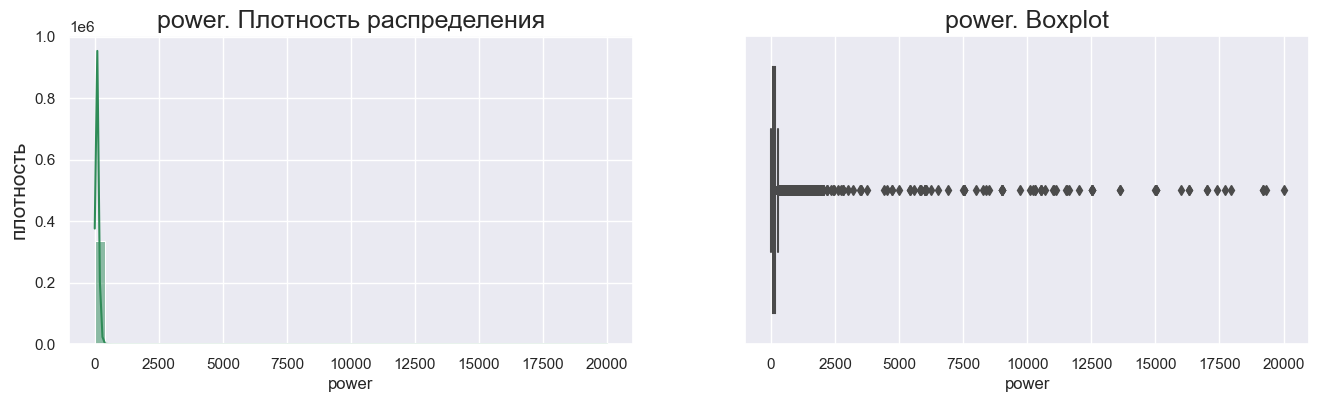

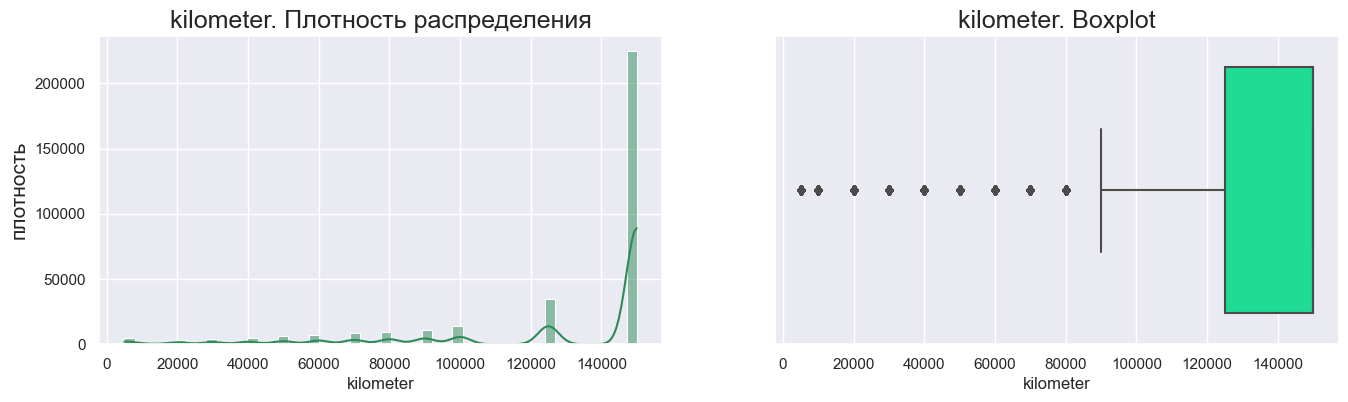

In [22]:
# построим графики гистограммы histplot и boxplot для количественных признаков 
columns_name = ['price', 'registration_year', 'power', 'kilometer']
for name in columns_name:
    graph(data[name], name, num_bins=50)

In [23]:
data.describe()

,price,registration_year,power,kilometer
count,334660.000000,334660.000000,334660.000000,334660.000000
mean,4504.372249,2003.924024,111.372659,128562.795076
std,4531.457109,69.377633,185.157391,37205.638630
min,0.000000,1000.000000,0.000000,5000.000000
25%,1150.000000,1999.000000,70.000000,125000.000000
50%,2800.000000,2003.000000,105.000000,150000.000000
75%,6500.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Проанализируем целевой признак price.

Видим, что имеются нулевые значения стоимости авто, что маловероятно, так же как и стоимость до 10 евро. Посмотрим на количество объектов с такой стоимостью.

In [24]:
data.query('price <= 10').pivot_table(index='price', values='brand', aggfunc='count')\
.sort_values(by='brand', ascending=False)

,brand
price,
0,8588
1,936
10,69
5,21
2,10
9,6
3,5
7,2
8,1


Больше всего объектов со стоимостью 0. Уберем значения менее 10 евро.

In [25]:
data = data.loc[data['price'] > 10]

Теперь рассмотрим признак год регистрации - менее 1900 (1886 - год изобретения автомобиля) и более 2016.

In [26]:
data.query('registration_year < 1900 | registration_year > 2016')\
.pivot_table(index='registration_year', values='brand', aggfunc='count')\
.sort_values(by='brand', ascending=False)

,brand
registration_year,
2017,8555
2018,3242
2019,15
1000,13
9999,13
5000,12
4000,3
7000,3
3000,3


Таких значений, действительно, не много. Можно предположить, что это опечатки. Удалим эти значения из базы данных.

In [27]:
data = data.loc[(data['registration_year'] >= 1900) & (data['registration_year'] <= 2016)]

Посмотрим признак мощность (power) менее 10 л.с.

In [28]:
data.query('power <= 10').pivot_table(index='power', values='brand', aggfunc='count')\
.sort_values(by='brand', ascending=False)

,brand
power,
0,28098
1,17
5,13
10,7
4,5
8,5
2,4
6,4
7,3


Более 30 тыс. объектов с мощностью 0. Возможно это машины, которые сломаны и поэтому указаны с такой мощностью. Посмотрим их стоимость.

In [29]:
data.query('power <= 10').pivot_table(index='repaired', values='price', aggfunc=['count', 'mean'])

,count,mean
,price,price
repaired,,
no,11043,3260.888708
unknown,13634,2093.093223
yes,3482,1267.833429


Скорее всего нулевая мощность никак не связана с ремонтными работами и невозможностью двигаться у авто, так как мощность 0 указана у машин без ремонта и средняя стоимость достаточно большая для сломанного транспорта. Кроме того, с мощностью до 10 л.с. также имеются объекты. Скорее всего, причиной мощности равной 0 является некорректная выгрузка/объединение данных.

Удалим эти значения.

In [30]:
data = data.loc[data['power']>10]

Пробег авто указан с округление и равными интервалами, видимо, владельцу необходимо было выбрать категорию, близкую к его фактическому пробегу. Здесь с распределением все нормально, нулевые значения отсутствуют.

In [31]:
print('Доля исключенных данных:', round((data_all.shape[0] - data.shape[0])/data_all.shape[0]*100, 2), '%', 
      'или', (data_all.shape[0] - data.shape[0]), 'объектов')

Доля исключенных данных: 19.58 % или 69393 объектов


**Выводы по итогам предобработки данных:**
   - удалены дубликаты (4 объекта);
   - удалены признаки, неинформативные для обучения модели ('DateCrawled', 'NumberOfPictures', 'DateCreated', 'PostalCode', 'LastSeen', 'RegistrationMonth');
   - преобразованы названия признаков в нижний змеиный регистр;
   - удалены пропущенные значения в признаки модели авто, так как без данной информации определение стоимости затруднительно;
   - прочие пропуски заполнены значением 'unknown' (пропуски наблюдались только в категориальных признаках);
   - выделены наиболее популярные критерии (категориальные признаки) авто в базе данных: 
        - брэнд: volkswagen;
        - модели: volkswagen golf, bmw 3er, volkswagen polo;
        - тип кузова: sedan, small и wagon;
        - коробка передач: ручная (manual);
        - тип топлива: бензин (petrol);
        - ремонт авто отсутствует.
   - удалены аномальные значения из количественных признаков.

По итогам предобработки данных было исключено 17.04% данных или 60374 объектов.

## Обучение моделей

### Функции для оптимизации работы с обучением моделей

In [32]:
def rmse(target, predict):
    mse = mean_squared_error(target, predict)
    return mse**0.5
rmse_score = make_scorer(rmse, greater_is_better=False)

In [33]:
# создадим функции для подбора параметров
# целевой метрикой качества выберем rmse_score
def gridsearch (model, params, features_train, target_train):
    '''подбирает гиперпараметры к модели с помощью GridSearchCV'''
    grid = GridSearchCV(model, params, n_jobs=-1, scoring=rmse_score, cv=5)
    grid.fit(features_train, target_train)
    print('Лучшие параметры модели:', grid.best_params_)
    print(f'{model}','RMSE: {:.2f}'.format(grid.best_score_))
    return grid

### Деление данных на выборки

In [34]:
# подготовим признаки и целевой признак
features = data.drop(['price'], axis=1)
target = data['price']

In [35]:
# разделим данные на выборки
features_train_v, features_test, target_train_v, target_test = train_test_split(
    features, target, test_size=0.2, random_state=SEED)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_v, target_train_v, test_size=0.25, random_state=SEED)

Проверим размеры выборок:

In [36]:
# обучающая выборка
features_train.shape[0]/features.shape[0]

0.5999957890599779

In [37]:
# валидационная выборка
features_valid.shape[0]/features.shape[0]

0.2000021054700111

In [38]:
# тестовая выборка
features_test.shape[0]/features.shape[0]

0.2000021054700111

### Подготовка признаков к обучению

Для категориальных признаков используем два вида кодирования:
- OneHotEncoder (для признаков с малым количеством классов)
- OrdinalEncoder (кодировка классов целочисленным массивом для признаков с большим количеством классов)

Использование OneHotEncoder для всех категориальных признаков значительно увеличит количество признаков (для каждого класса будет создан отдельный бинарный признак), что повлияет на скорость обучения.

Так как OrdinalEncoder имеет недостаток в части создания ложных взаимосвязей (номинальные переменные) при линейных моделях (чем больше цифра класса в признаки, тем приоритетнее он воспринимается моделью), то попробуем обойти это, используя только "деревянные" модели.

Так как для моделей, основанных на деревьях, стандартизация (нормализация) данных перед обучением никак не влияет на качество предсказаний, то шкалирование проводить не будем.
    

In [39]:
# создаем списки признаков для разных видов кодировок
ord_cols = ['vehicle_type', 'model', 'fuel_type', 'brand']
ohe_cols = ['gearbox', 'repaired']

In [40]:
# преобразуем обучающую выборку
col_transformer_1 = make_column_transformer(
    (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ord_cols),
    (OneHotEncoder(drop='first', handle_unknown='ignore'), ohe_cols),
    remainder='passthrough')

features_train_1 = pd.DataFrame(col_transformer_1.fit_transform(features_train), index=features_train.index,
                                                     columns=col_transformer_1.get_feature_names_out())
features_train_1.head()

,ordinalencoder__vehicle_type,ordinalencoder__model,ordinalencoder__fuel_type,ordinalencoder__brand,onehotencoder__gearbox_manual,onehotencoder__gearbox_unknown,onehotencoder__repaired_unknown,onehotencoder__repaired_yes,remainder__registration_year,remainder__power,remainder__kilometer
66503,6.0,242.0,2.0,38.0,0.0,0.0,0.0,0.0,2011.0,215.0,150000.0
73069,4.0,169.0,2.0,37.0,0.0,0.0,0.0,0.0,2006.0,140.0,150000.0
70744,5.0,142.0,6.0,37.0,1.0,0.0,0.0,0.0,1999.0,50.0,150000.0
32156,4.0,15.0,6.0,2.0,1.0,0.0,0.0,0.0,1997.0,170.0,150000.0
46780,4.0,42.0,2.0,24.0,1.0,0.0,0.0,0.0,2012.0,131.0,100000.0


In [41]:
# преобразуем валидационную выборку
features_valid_1 = pd.DataFrame(col_transformer_1.transform(features_valid), index=features_valid.index,
                                                     columns=col_transformer_1.get_feature_names_out())
features_valid_1.head()

,ordinalencoder__vehicle_type,ordinalencoder__model,ordinalencoder__fuel_type,ordinalencoder__brand,onehotencoder__gearbox_manual,onehotencoder__gearbox_unknown,onehotencoder__repaired_unknown,onehotencoder__repaired_yes,remainder__registration_year,remainder__power,remainder__kilometer
55236,0.0,47.0,2.0,20.0,1.0,0.0,0.0,0.0,2011.0,136.0,60000.0
306319,8.0,59.0,6.0,20.0,1.0,0.0,0.0,0.0,2002.0,143.0,150000.0
154699,0.0,149.0,6.0,24.0,1.0,0.0,0.0,0.0,2011.0,120.0,50000.0
312666,8.0,31.0,2.0,1.0,1.0,0.0,0.0,0.0,2005.0,180.0,150000.0
83147,4.0,59.0,6.0,20.0,1.0,0.0,0.0,0.0,2008.0,184.0,60000.0


In [42]:
#проверим количество признаков в выборках
(features_train_1.columns != features_valid_1.columns).sum()

0

### Подбор гиперпараметров для моделей

In [43]:
# гиперпараметры для разных моделей
cb_params = {'iterations': [1000],
            'learning_rate': [0.03, 0.1],
            'depth': [6, 8],
            'l2_leaf_reg': [1, 3],
            'logging_level': ['Silent'],
            'loss_function':['RMSE']}

lgbm_params = {'n_estimators': [1000, 1200],
               'max_depth': [12, 14]}

tree_params = {'max_depth': [10,15,20],
              'min_samples_leaf':range (2,11,2),
              'min_samples_split':range(2,11,2)}

forest_params = {'n_estimators': [10,20],
                   'max_depth':[5,15],
                   'min_samples_leaf':[2,7],
                   'min_samples_split':[2,8]}

Перед тем, как мы начнем обучение моделей, создадим константную модель (dummy), которая всегда предсказывает наиболее часто встречающийся класс. Это позволит проводить сравнительную оценку метрик качества моделей.

In [44]:
# создаем и обучаем модель со средним значением целевого признака
dummy_clf = DummyRegressor(strategy='mean')
dummy_clf.fit(features_train_1, target_train)
predictions_valid = dummy_clf.predict(features_valid_1)
rmse_dummy = rmse(target_valid, predictions_valid)
print("RMSE на валидационной выборке: %.2f" % rmse_dummy)

RMSE на валидационной выборке: 4636.19


Видим, что результат метрики RMSE выше целевого уровня (необходимо получить RMSE ниже 2500). Далее сравним результат dummy модели с результатами предсказания обученных моделей.

#### CatBoostRegressor

In [45]:
# %%time
# cb_grid = gridsearch(CatBoostRegressor(random_state=SEED), cb_params, features_train_1, target_train)

Лучшие параметры модели: {'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.1, 'logging_level': 'Silent', 'loss_function': 'RMSE'}
<catboost.core.CatBoostRegressor object at 0x000002D323473700> RMSE: -1528.98
CPU times: total: 1min 45s
Wall time: 13min 57s


Для экономии времени загрузки модели с лучшими параметрами, сохраним параметры и полученную модель в переменные.

In [46]:
cb_grid = CatBoostRegressor(random_state=SEED, depth=8, iterations = 1000, l2_leaf_reg=1, learning_rate=0.1, 
                            logging_level='Silent', loss_function='RMSE')

In [47]:
%%time
y_pred_cat = cb_grid.fit(features_train_1, target_train).predict(features_train_1)

CPU times: total: 1min 45s
Wall time: 33.2 s


In [48]:
cbr_rmse = rmse(target_train, y_pred_cat)
print("RMSE: %.2f" % cbr_rmse) 

RMSE: 1363.69


#### LGBMRegressor

In [49]:
# %%time
# lgbm_grid = gridsearch(LGBMRegressor(random_state=SEED), lgbm_params, features_train_1, target_train)

Лучшие параметры модели: {'max_depth': 14, 'n_estimators': 1200}
LGBMRegressor(random_state=12345) RMSE: -1520.68
CPU times: total: 22.8 s
Wall time: 2min 27s


Для экономии времени загрузки модели с лучшими параметрами, сохраним параметры и полученную модель в переменные.

In [50]:
lgbm_grid = LGBMRegressor(random_state=SEED, max_depth = 14, n_estimators = 1200)

In [51]:
%%time
y_pred_lgbm = lgbm_grid.fit(features_train_1, target_train).predict(features_train_1)

CPU times: total: 40.5 s
Wall time: 10.8 s


In [52]:
lgbm_rmse = rmse(target_train, y_pred_lgbm)
print("RMSE: %.2f" % lgbm_rmse) 

RMSE: 1320.18


#### RandomForestRegressor

In [53]:
# %%time
# forest_grid = gridsearch(RandomForestRegressor(random_state=SEED), forest_params, features_train_1, target_train)

Лучшие параметры модели: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20}
RandomForestRegressor(random_state=12345) RMSE: -1636.02
CPU times: total: 9.91 s
Wall time: 3min 37s


Для экономии времени загрузки модели с лучшими параметрами, сохраним параметры и полученную модель в переменные.

In [54]:
forest_grid = RandomForestRegressor(random_state=SEED, max_depth=15, n_estimators=20, min_samples_leaf=2, min_samples_split=2)

In [55]:
%%time
y_pred_forest = forest_grid.fit(features_train_1, target_train).predict(features_train_1)

CPU times: total: 9.22 s
Wall time: 9.45 s


In [56]:
forest_rmse = rmse(target_train, y_pred_forest)
print("RMSE: %.2f" % forest_rmse) 

RMSE: 1332.81


#### DecisionTreeRegressor и BaggingRegressor

In [57]:
# %%time
# tree_grid = gridsearch(DecisionTreeRegressor(random_state=SEED), tree_params, features_train_1, target_train)

Лучшие параметры модели: {'max_depth': 20, 'min_samples_leaf': 8, 'min_samples_split': 2}
DecisionTreeRegressor(random_state=12345) RMSE: -1774.56
CPU times: total: 4 s
Wall time: 2min 3s


Для экономии времени загрузки модели с лучшими параметрами, сохраним параметры и полученную модель в переменные.

In [58]:
tree_grid = DecisionTreeRegressor(random_state=SEED, max_depth=20, min_samples_leaf=8, min_samples_split=2)

In [59]:
bagging_tree = BaggingRegressor(tree_grid, n_estimators=150, random_state=SEED)

In [60]:
%%time
y_pred_bagging_tree = bagging_tree.fit(features_train_1, target_train).predict(features_train_1)

CPU times: total: 1min 19s
Wall time: 1min 22s


In [61]:
bagging_tree_rmse = rmse(target_train, y_pred_bagging_tree)
print("RMSE: %.2f" % bagging_tree_rmse) 

RMSE: 1418.37


In [62]:
models_simile_train = pd.DataFrame([cbr_rmse, lgbm_rmse, forest_rmse,bagging_tree_rmse], 
                                   columns=['RMSE на обучающей выборке'], 
                                   index=['CatBoost','LGBM','RandomForest', 'BaggingTree'])
models_simile_train

,RMSE на обучающей выборке
CatBoost,1363.688962
LGBM,1320.183522
RandomForest,1332.807237
BaggingTree,1418.372512


RMSE всех обученных моделей соответствует целевому значению (менее 2500). Проверим модели на валидационной выборке.

## Анализ моделей

Теперь проверим модели на валидационной выборке, оценим время обучения и предсказания.

In [63]:
# сравним модели по времени обучения и RMSE на валидационной выбрке
grid_models = {}
grid_models['CatBoost'] = cb_grid
grid_models['LGBM'] = lgbm_grid
grid_models['Forest'] = forest_grid
grid_models['Bagging_tree'] = bagging_tree

model_results = []
models = []

for key in grid_models:
    model_result = []
    model = grid_models[key]
    models.append(key)
    start_time = time.time()
    train_fit = model.fit(features_train_1, target_train)
    time_fit = time.time() - start_time
    model_result.append(round(time_fit,2))
    
    start_time = time.time()
    predict = model.predict(features_valid_1)
    time_predict = time.time() - start_time
    model_result.append(round(time_predict,2))
    model_result.append(round((time_fit + time_predict),2))
    model_result.append(round(rmse(target_valid, predict),2))
    model_results.append(model_result)

In [64]:
models_simile = pd.DataFrame(model_results, columns=['Время обучения, сек.', 'Время предсказания, сек.', 'Общее время, сек.', 
                                                     'RMSE на валид. выборке'], index=models)
models_simile

,"Время обучения, сек.","Время предсказания, сек.","Общее время, сек.",RMSE на валид. выборке
CatBoost,31.97,0.05,32.03,1529.46
LGBM,8.39,1.70,10.09,1513.85
Forest,8.49,0.22,8.72,1624.39
Bagging_tree,70.51,3.41,73.92,1618.82


<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Молодец, что для сравнения моделей заносишь их в общий датафрейм 👍
</div>

Модель с лучшими результатами по соотношению RMSE и общему времени обучения и предсказания - LGBMRegressor. Используем ее для тестирования.

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Вывод соответствует анализу 👍 Значит рекомендуем заказчику LGBM
</div>

## Тестирование модели

Перед тестированием обучим модель на обучающей и валидационной выборках, чтобы улучшить качество модели (обучим на большем количестве данных).

In [65]:
# преобразуем общую выборку (обучающая и валидационная)
features_train_total = pd.DataFrame(col_transformer_1.fit_transform(features_train_v), index=features_train_v.index,
                                                     columns=col_transformer_1.get_feature_names_out())
features_train_total.head()

,ordinalencoder__vehicle_type,ordinalencoder__model,ordinalencoder__fuel_type,ordinalencoder__brand,onehotencoder__gearbox_manual,onehotencoder__gearbox_unknown,onehotencoder__repaired_unknown,onehotencoder__repaired_yes,remainder__registration_year,remainder__power,remainder__kilometer
280630,2.0,166.0,6.0,35.0,1.0,0.0,0.0,0.0,2003.0,143.0,125000.0
241741,8.0,103.0,2.0,10.0,1.0,0.0,0.0,0.0,2009.0,109.0,90000.0
323707,5.0,116.0,6.0,37.0,1.0,0.0,0.0,0.0,1999.0,60.0,150000.0
140594,5.0,116.0,6.0,37.0,1.0,0.0,0.0,0.0,1999.0,101.0,150000.0
339385,7.0,174.0,7.0,23.0,1.0,0.0,0.0,1.0,2016.0,140.0,150000.0


In [66]:
# преобразуем тестовую выборку
features_test_1 = pd.DataFrame(col_transformer_1.transform(features_test), index=features_test.index,
                                                     columns=col_transformer_1.get_feature_names_out())
features_test_1.head()

,ordinalencoder__vehicle_type,ordinalencoder__model,ordinalencoder__fuel_type,ordinalencoder__brand,onehotencoder__gearbox_manual,onehotencoder__gearbox_unknown,onehotencoder__repaired_unknown,onehotencoder__repaired_yes,remainder__registration_year,remainder__power,remainder__kilometer
4265,5.0,55.0,6.0,5.0,1.0,0.0,0.0,0.0,2004.0,73.0,150000.0
78384,8.0,95.0,6.0,20.0,0.0,0.0,0.0,0.0,2007.0,386.0,150000.0
169778,4.0,116.0,6.0,37.0,1.0,0.0,1.0,0.0,1998.0,101.0,150000.0
30090,1.0,106.0,6.0,32.0,0.0,0.0,0.0,0.0,2011.0,84.0,30000.0
243166,8.0,15.0,6.0,2.0,1.0,0.0,0.0,1.0,1999.0,150.0,150000.0


In [67]:
#проверим количество признаков в выборках
(features_train_total.columns != features_test_1.columns).sum()

0

In [68]:
start_time = time.time()
y_pred_test = lgbm_grid.fit(features_train_total, target_train_v).predict(features_test_1)
time_fit_pred = round((time.time() - start_time),2)
print('RMSE на тестовой выборке:', round(rmse(target_test, y_pred_test),2))
print('Общее время обучения и предсказания:', time_fit_pred, 'секунд')

RMSE на тестовой выборке: 1486.82
Общее время обучения и предсказания: 11.43 секунд


Результаты dummy модели:

In [69]:
dummy_clf.fit(features_train_total, target_train_v)
predictions_test = dummy_clf.predict(features_test_1)
rmse_dummy = rmse(target_test, predictions_test)
print("RMSE на тестовой выборке: %.2f" % rmse_dummy)

RMSE на тестовой выборке: 4596.55


Полученные результаты тестирования модели удовлетворяют поставленным целям проекта:
- RMSE ниже 2500;
- выбрана модель с оптимальным соотношением времени обучения и предсказания и RMSE (среди построенных).

Обученная модель показывает RMSE (1486.82) почти в 3 раза меньше, чем dummy модель (4596.55).

## Выводы по результатам проекта

**В ходе проекта были выполнены следующие этапы:**

- Проведена предобработка данных и подготовка их к построению модели.
- Проведен подбор гиперпараметров c помощью GridSearchCV.
- Обучены и оценены результаты следующих моделей: 

In [70]:
models_simile

,"Время обучения, сек.","Время предсказания, сек.","Общее время, сек.",RMSE на валид. выборке
CatBoost,31.97,0.05,32.03,1529.46
LGBM,8.39,1.70,10.09,1513.85
Forest,8.49,0.22,8.72,1624.39
Bagging_tree,70.51,3.41,73.92,1618.82


Модель LGBMRegressor с лучшими результатами по RMSE и общему времени обучения и предсказания выбрана для тестирования.

В ходе тестирования получены следующие результаты:

- RMSE на тестовой выборке: 1486.82
- Общее время обучения и предсказания: 11.43 секунд
- Результаты предсказания модели сравнили с моделью dummy, которая показала итоговый RMSE в 3 раза больше (4596.55).
